In [1]:
!pip install opencv-python

In [2]:
%load_ext autoreload
%autoreload 2
import img_text_composition_models
from enum import Enum
import datasets
import torchvision
import torch
from main import load_dataset, create_model_and_optimizer
import test_retrieval
from tqdm import tqdm
import cv2

In [15]:
class opt_config:
    def __init__(self):
        self.dataset = "css3d"
        self.dataset_path = "../data/CSSDataset/CSS-vn-vanilla-v2.json" 
        self.model = "tirg" 
        self.loss = "soft_triplet" 
        self.comment = "css3d_tirg"
        self.embed_dim = 512
        self.learning_rate = 1e-2
        self.weight_decay = 1e-6 
        self.f = ""
        self.learning_rate_decay_frequency = 99999999
        self.batch_size = 32
        self.num_epochs = 100
        self.n_epochs_valudations = 5
        self.loader_num_workers = 4
        self.pretrained_weights = "runs/Sep23_05-38-54_ai-servers-3css_vn_vanilla_v2/latest_checkpoint.pth"
        
opt = opt_config()

trainset, testset = load_dataset(opt)
texts = [t for t in trainset.get_all_texts()]
model = img_text_composition_models.TIRG(texts, embed_dim=opt.embed_dim)

Reading dataset  css3d
trainset size: 19012
testset size: 19057


In [16]:
model, optimizer = create_model_and_optimizer(opt, [t for t in trainset.get_all_texts()])

Creating model and optimizer for tirg
Pretrained model from runs/Sep23_05-38-54_ai-servers-3css_vn_vanilla_v2/latest_checkpoint.pth


# Get a random images

In [17]:
ab = trainset.generate_random_query_target()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


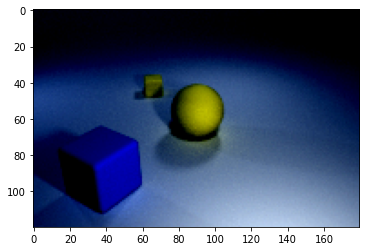

In [18]:
import matplotlib.pyplot as plt
plt.imshow(ab["source_img_data"].permute(1,2,0))

In [19]:
!pip install ipdb

# Read and load image from index

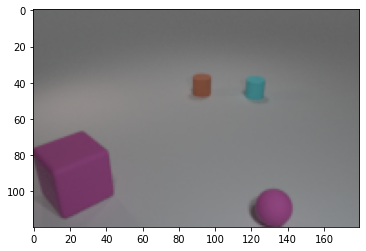

In [20]:
idx = 3
idx_fill = str(idx).zfill(6)
img = cv2.imread(f"../data/CSSDataset/images/css_test_{idx_fill}.png") 
plt.imshow(img)

In [21]:
imgs = []

In [22]:
test_queries = testset.get_test_queries()
train_queries = trainset.get_test_queries()
all_imgs = []
all_captions = []
all_queries = []
all_target_captions = []
queries_dict = {"train": trainset, "test": testset}
chosen_set_str = "train" # test or train
chosen_set = queries_dict[chosen_set_str]
num_img_to_get = 3 
n=5000

if test_queries:
    # compute test query features
    imgs = []
    mods = []
    for t in tqdm(test_queries[:n]):
        imgs += [testset.get_img(t["source_img_id"])]
        mods += [t["mod"]["str"]]
        if len(imgs) >= opt.batch_size or t is test_queries[-1]:
            if "torch" not in str(type(imgs[0])):
                imgs = [torch.from_numpy(d).float() for d in imgs]
            
            imgs = torch.stack(imgs).float()
            imgs = torch.autograd.Variable(imgs).cuda()
            mods = [t for t in mods]
            f = model.compose_img_text(imgs, mods).data.cpu().numpy()
            all_queries += [f]
            imgs = []
            mods = []
     # compute all image features
    imgs = []
    for i in tqdm(list(range(len(testset.imgs)))):
        imgs += [testset.get_img(i)]
        if len(imgs) >= opt.batch_size or i == len(testset.imgs) - 1:
            if "torch" not in str(type(imgs[0])):
                imgs = [torch.from_numpy(d).float() for d in imgs]
            imgs = torch.stack(imgs).float()
            imgs = torch.autograd.Variable(imgs).cuda()
            imgs = model.extract_img_feature(imgs).data.cpu().numpy()
            all_imgs += [imgs]
            imgs = []
    all_imgs = np.concatenate(all_imgs)
    all_captions = [img["captions"][0] for img in testset.imgs]
            

import ipdb
# feature normalization
for i in range(all_queries.shape[0]):
    ipdb.set_trace()
    all_queries[i, :] /= np.linalg.norm(all_queries[i, :])
for i in range(all_imgs.shape[0]):
    all_imgs[i, :] /= np.linalg.norm(all_imgs[i, :])

# match test queries to target images, get nearest neighbors
sims = all_queries.dot(all_imgs.T)
if test_queries:
    for i, t in enumerate(test_queries):
        sims[i, t["source_img_id"]] = -10e10  # remove query image
nn_result = [np.argsort(-sims[i, :])[:110] for i in range(sims.shape[0])]

# compute recalls
out = []
nn_result = [[all_captions[nn] for nn in nns] for nns in nn_result]
for k in [1, 5, 10, 50, 100]:
    r = 0.0
    for i, nns in enumerate(nn_result):
        if all_target_captions[i] in nns[:k]:
            r += 1
    r /= len(nn_result)
    out += [("recall_top" + str(k) + "_correct_composition", r)]
    
    if opt.dataset == "mitstates":
        r = 0.0
        for i, nns in enumerate(nn_result):
            if all_target_captions[i].split()[0] in [c.split()[0] for c in nns[:k]]:
                r += 1
        r /= len(nn_result)
        out += [("recall_top" + str(k) + "_correct_adj", r)]

        r = 0.0
        for i, nns in enumerate(nn_result):
            if all_target_captions[i].split()[1] in [c.split()[1] for c in nns[:k]]:
                r += 1
        r /= len(nn_result)
        out += [("recall_top" + str(k) + "_correct_noun", r)]

  9%|███████                                                                      | 1759/19057 [00:21<03:32, 81.57it/s]


KeyboardInterrupt: 

- imgs là tensor `[batch_size, 3,120,180]`
- texts là list str len `batch_size`

In [ ]:
imgs

# Reconstruction
To perform reconstruction, one needs:
- Image + text
- Its representation in TIRG


In [ ]:
sample = trainset.generate_random_query_target()
sample

In [ ]:
imgs = torch.unsqueeze(sample['source_img_data'],0).cuda()
texts = sample['mod']['str']
model.compose_img_text(imgs, [texts])